# Biomedical Image Analysis in Python: 2

In [1]:
import numpy as np
import scipy
import imageio
from imageio import imread
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
#from pprint import pprint
#import scipy.ndimage as ndi
#from skimage.color import rgb2gray, rgba2rgb
#from skimage import exposure

plt.rcParams['figure.figsize'] = (10, 8)

In [2]:
def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [3]:
def plot_comparison(original, original_title, filtered, title_filtered):
    
    fig, (ax1, ax2) = plt.subplots(ncols= 2, figsize=(12, 8), sharex= True, sharey= True)
    ax1.imshow(original, cmap = plt.cm.gray)
    ax1.set_title(original_title)
    ax1.axis('off')
    ax2.imshow(filtered, cmap= plt.cm.gray)
    ax2.set_title(title_filtered)
    ax2.axis('off')

In [4]:
def format_and_render_plot_1():
    '''Custom function to simplify common formatting operations for exercises. Operations include: 
    1. Turning off axis grids.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    for ax in fig.axes:
        ax.axis('off')    
    plt.tight_layout()
    plt.show()

In [5]:
def format_and_render_plot_2():
    '''Custom function to simplify common formatting operations for exercises. Operations include: 
    1. Turning off axis grids.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    for ax in fig.axes:
        ax.legend(loc='center right')
    plt.show()

In [153]:
def intersection_of_union(im1, im2):
    i = np.logical_and(im1, im2)
    u = np.logical_or(im1, im2)
    return i.sum() / u.sum()

# $\star$ Chapter 3: Measurement

In this chapter, you'll get to the heart of image analysis: object measurement. Using a 4D cardiac time series, you'll determine if a patient is likely to have heart disease. Along the way, you'll learn the fundamentals of image segmentation, object labeling, and morphological measurement.

## Objects and Labels
* In this chapter, we'll discuss how you can measure one or more component parts of your image. We'll start by learning how to label objects.
* **Segmentation** is the process of splitting an image into separate objects
    * Since whole careers can be spent on developing segmentation techniques, we will focus mostly on how to analyze the resulting objects
* For this chapter, we will analyze cardiac magnetic resonance imaging data from the Sunnybrook Cardiac Database.
* Each Sunnybrook dataset contains a 3D time series of a person's heart over the course of a single heartbeat.
* The end goal is to measure the proportion of blood that's pumped out of the left ventricle, a measure known as **ejection fraction**
* **Ejection fraction:** the proportion of blood pumped out of the heart's left ventricle (LV).

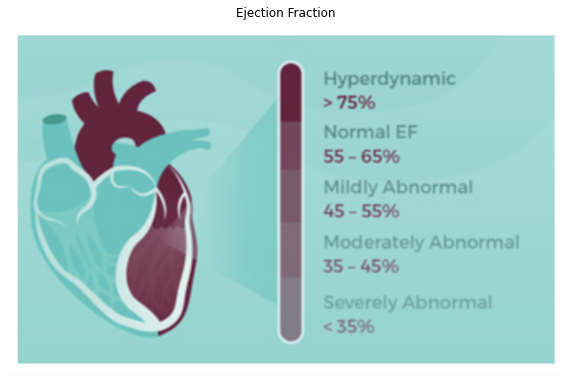

In [6]:
show_image(imread('pics_b/ejection_fraction.png'), "Ejection Fraction")

* Abnormal ejection fractions can indicate urgent health issues. 
* The first step towards calculating the ejection fraction is to segment the left ventricle from the rest of the image. 
* For MRI data, fluid-filled areas have high-intensity values, so one approach is to take the original image, filter it to reduce noise and smooth edges, then mask it to select pixels with relatively high values. 

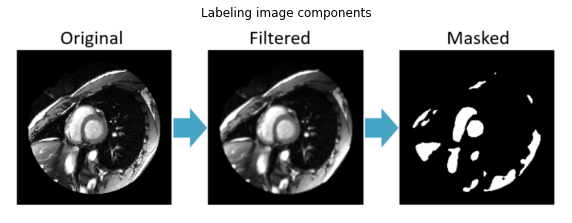

In [7]:
show_image(imread('pics_b/ef_filtered_masked.png'), "Labeling image components")

* This does a good job of segmenting the left ventricle, but now we need to remove the pixels that are part of other objects

### Labeling image components
* To do this we use scipy's `label()` function.
* First, we'll create the mask seen in the image above by reading in the file, applying a small Gaussian filter, then masking pixels with intensities lower than 150.
* Next, we "label" the mask

```
import scipy.ndimages as ndi
im = imageio.imread('SCD4201-2d.dcm')
filt = ndi.gaussian_filter(im, sigma=2)

mask = filt > 150
labels, nlabels = ndi.label(mask)
```
* **The labeling algorithm treats 0 values as background pixels, and then it looks for all of the objects that are separated by background.**
    * **It then returns an array where each object has been indexed, as well as the number of objects detected.**
    
```
nlabels
```
* output: `14`

* In the above example, we have detected 14 distinct objects in the image.
* Plotting the labels with the rainbow colormap shows that the circular left ventricle region in the center has been assigned a unique label value.

```
plt.imshow(label, cmap= 'rainbow')
plt.axis('off')
plt.show()
```

### Label selection
Select a single label within an image:

```
np.where(labels == 1, im , 0)
```
* You can now select individual objects by referencing their index value
* To select pixels in the first object, you would use `where label is 1, return the value from im, else return 0.`
* Alternatively, you can select a number of labels meeting a condition:

```
np.where(labels < 3, im, 0)
```
* To select many labels within the image, call `where labels is less than 3, return im, else return 0.`
    * This will select pixels from the first and second objects
    
### Object extraction 
* **Bounding box:** range of pixels that completely encloses an object.

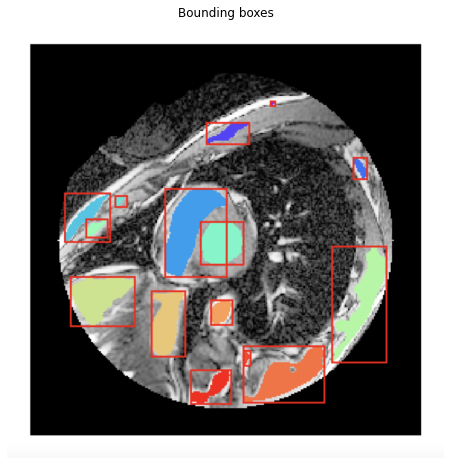

In [8]:
show_image(imread('pics_b/object_extraction.png'), "Bounding boxes")

* A **bounding box** is the range of indices along each axis which completely enclose an object (see the red boxes above).
* You can use the bounding box to extract objects from the larger image
* **`ndi.find_objects()`** returns a list of bounding box coordinates
* When you run `find_objects()` on a labeled array, it will return a list of bounding boxes

```
labels, nlabels = ndi.label(mask)
boxes = ndi.find_objects(labels)
```
* output: `(slice(116, 139), slice(120, 141))`

* Each item in the returned list is a tuple of index ranges- one slice for each dimension.
* **Indexing the original image using one of these boxes will yield an image cropped to that object**
* You could then analyze each of these arrays individually.

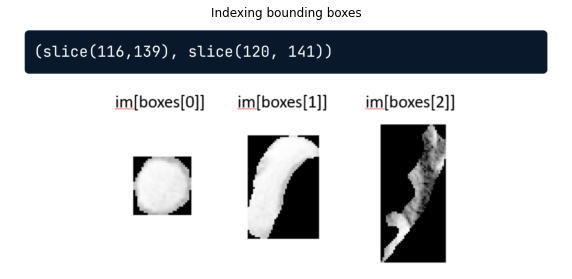

In [9]:
show_image(imread('pics_b/indexing_bboxes.png'), "Indexing bounding boxes")

### Exercises: Segment the heart
In this chapter, we'll work with [magnetic resonance (MR)](https://en.wikipedia.org/wiki/Magnetic_resonance_imaging) imaging data from the [Sunnybrook Cardiac Dataset](http://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/). The full image is a 3D time series spanning a single heartbeat. These data are used by radiologists to measure the *ejection fraction*: the proportion of blood ejected from the left ventricle during each stroke.

To begin, segment the left ventricle from a single slice of the volume (`im`). First, you'll filter and mask the image; then you'll label each object with `ndi.label()`.

This chapter's exercises have the following imports:

```
import imageio
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
```

In [6]:
im = imageio.imread('sunnybrook-cardiac-mr/SCD2001_006/SCD2001_MR_117.dcm')

FileNotFoundError: No such file: '/Users/abigailmorgan/Projects/Springboard/Notes/Image_Processing/Biomedical_Image_Analysis/sunnybrook-cardiac-mr/SCD2001_006/SCD2001_MR_117.dcm'

In [3]:
heart_im = imread('sunnybrook-cardiac-mr/SCD2001_006/SCD2001_MR_117.dcm')

FileNotFoundError: No such file: '/Users/abigailmorgan/Projects/Springboard/Notes/Image_Processing/Biomedical_Image_Analysis/sunnybrook-cardiac-mr/SCD2001_006/SCD2001_MR_117.dcm'

In [4]:
show_image(heart_im, "Heart image")

NameError: name 'heart_im' is not defined

```
# Smooth intensity values
im_filt = ndi.median_filter(im, size=3)

# Select high-intensity pixels
mask_start = np.where(im_filt > 60, 1, 0)
mask = ndi.binary_closing(mask_start)

# Label the objects in "mask"
labels, nlabels = ndi.label(mask)
print('Num. Labels:', nlabels)
```

In [12]:
# Smooth intensity values
im_filt = ndi.median_filter(heart_im, size=3)

# Select high-intensity pixels
mask_start = np.where(im_filt > 60, 1, 0)
mask = ndi.binary_closing(mask_start)

# Label the objects in "mask"
labels, nlabels = ndi.label(mask)
print('Num. Labels:', nlabels)

Num. Labels: 26


Plot the `labels` array on top of the original image. To create an overlay, use `np.where` to convert values of 0 to `np.nan`. Then, plot the overlay with the `rainbow` colormap and set `alpha=0.75` to make it transparent.

```
# Create a `labels` overlay
overlay = np.where(labels>0, labels, np.nan)

# Use imshow to plot the overlay
plt.imshow(overlay, cmap='rainbow', alpha=0.75)
format_and_render_plot()
```

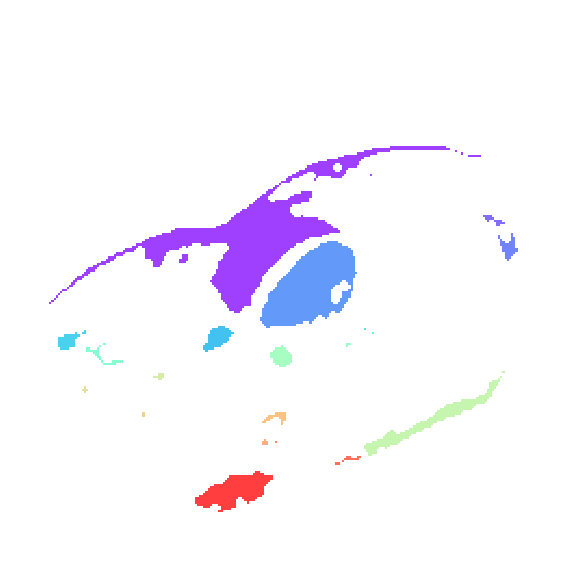

In [13]:
# Create a `labels` overlay
overlay = np.where(labels>0, labels, np.nan)

# Use imshow to plot the overlay
plt.imshow(overlay, cmap='rainbow', alpha=0.75)
format_and_render_plot_1()

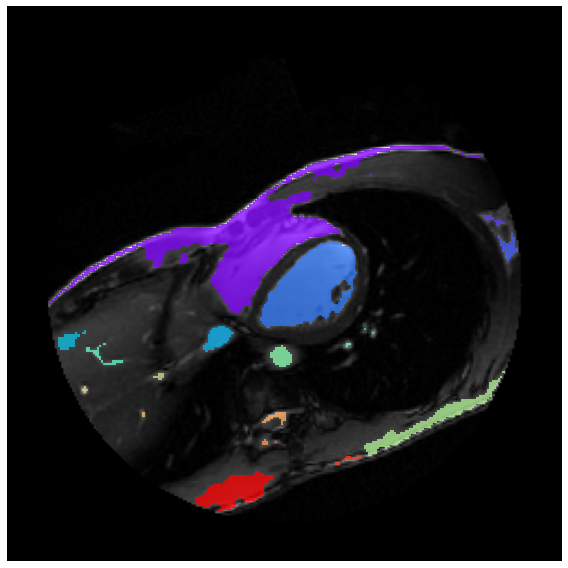

In [14]:
plt.imshow(heart_im, cmap='gray')
plt.imshow(overlay, cmap='rainbow', alpha=0.75)
format_and_render_plot_1()

### Select objects
Labels are like object "handles" - they give you a way to pick up whole sets of pixels at a time. To select a particular object:

1. Find the label value associated with the object.
2. Create a mask of matching pixels.

For this exercise, create a labeled array from the provided `mask`. Then, find the label value for the centrally-located left ventricle, and create a mask for it.

If you know the location of the left ventricle, you can find its value by indexing it, a la:

```
lv_val = labels[128, 128]
mask = np.where(labels == lv_val, 1, np.nan)
```
Exercise:

```
# Label the image "mask"
labels, nlabels = ndi.label(mask)

# Select left ventricle pixels
lv_val = labels[128, 128]
lv_mask = np.where(labels == lv_val, 1, np.nan)

# Overlay selected label
plt.imshow(lv_mask, cmap='rainbow')
plt.show()
```

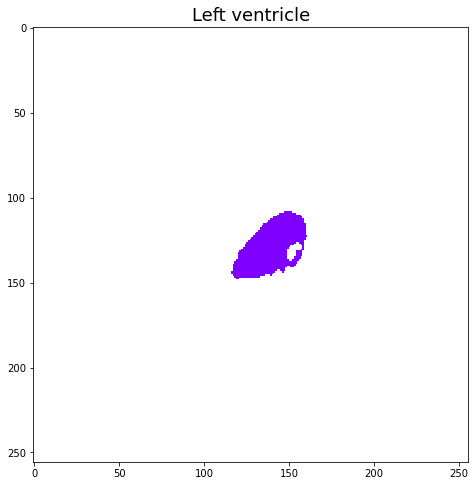

In [15]:
# Label the image "mask"
labels_lv, nlabels = ndi.label(mask)

# Select left ventricle pixels
lv_val = labels_lv[128, 128]
lv_mask = np.where(labels_lv == lv_val, 1, np.nan)

# Overlay selected label
plt.imshow(lv_mask, cmap='rainbow')
plt.title("Left ventricle", fontsize=18)
plt.show()

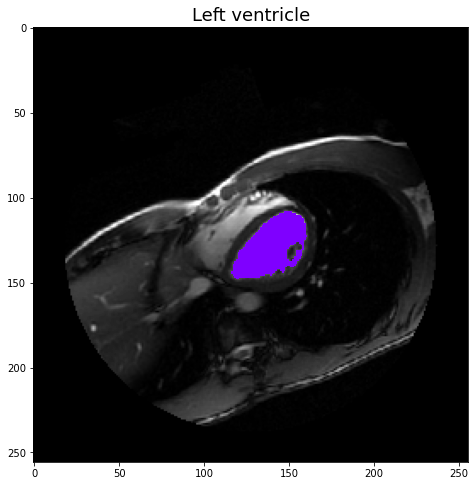

In [17]:
plt.imshow(heart_im, cmap='gray')
plt.imshow(lv_mask, cmap='rainbow')
plt.title("Left ventricle", fontsize=18)
plt.show()

#### Exercises: Extract objects
Extracting objects from the original image eliminates unrelated pixels and provides new images that can be analyzed independently.

The key is to crop images so that they only include the object of interest. The range of pixel indices that encompass the object is the [bounding box](https://en.wikipedia.org/wiki/Minimum_bounding_box).

For this exercise, use `ndi.find_objects()` to create a new image containing only the *left ventricle*.

```
# Create left ventricle mask
labels, nlabels = ndi.label(mask)
lv_val = labels[128, 128]
lv_mask = np.where(labels == lv_val, 1, 0)
```

In [23]:
# Create left ventricle mask
labels_lv, nlabels = ndi.label(mask)
lv_val = labels_lv[128, 128]
lv_mask = np.where(labels_lv == lv_val, 1, 0)

In [24]:
boxes = ndi.find_objects(labels_lv)
print(boxes)

[(slice(64, 142, None), slice(19, 219, None)), (slice(77, 79, None), slice(167, 169, None)), (slice(96, 102, None), slice(219, 230, None)), (slice(104, 118, None), slice(225, 236, None)), (slice(107, 149, None), slice(116, 162, None)), (slice(138, 140, None), slice(66, 68, None)), (slice(147, 160, None), slice(89, 105, None)), (slice(148, 159, None), slice(23, 37, None)), (slice(148, 150, None), slice(164, 166, None)), (slice(150, 152, None), slice(168, 170, None)), (slice(152, 153, None), slice(64, 65, None)), (slice(155, 166, None), slice(35, 54, None)), (slice(155, 158, None), slice(155, 159, None)), (slice(156, 167, None), slice(121, 132, None)), (slice(161, 165, None), slice(81, 85, None)), (slice(168, 208, None), slice(163, 230, None)), (slice(169, 173, None), slice(67, 73, None)), (slice(175, 179, None), slice(34, 38, None)), (slice(186, 190, None), slice(61, 64, None)), (slice(187, 195, None), slice(117, 130, None)), (slice(199, 203, None), slice(117, 122, None)), (slice(200, 2

In [25]:
# Find bounding box of left ventricle
bboxes = ndi.find_objects(lv_mask)
print('Number of objects:', len(bboxes))
print('Indices for first box:', bboxes[0])

Number of objects: 1
Indices for first box: (slice(107, 149, None), slice(116, 162, None))


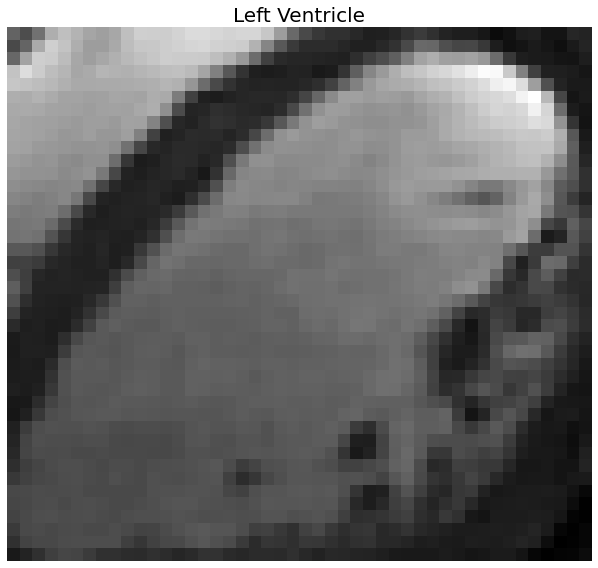

In [26]:
# Crop to the left ventricle (index 0)
im_lv = heart_im[bboxes[0]]

# Plot the cropped image
plt.imshow(im_lv, cmap='gray')
plt.title("Left Ventricle", fontsize=20)
format_and_render_plot_1()

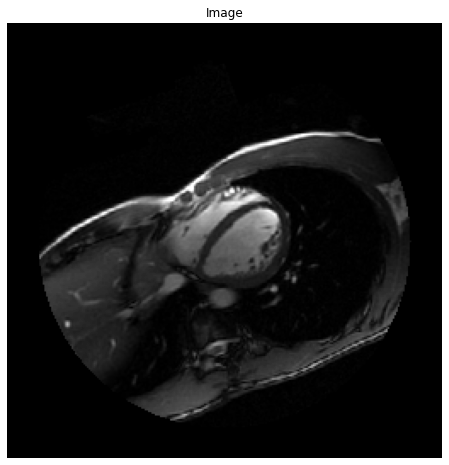

In [27]:
show_image(heart_im)

***

### Process start-to-finish

* **Segmentation** splits an image into separate objects
* End goal of this unity is to measure the proportion of blood that's pumped out of the left ventricle, a measure known as the **ejection fraction**


* First step is to **segment the left ventricle from the rest of the image**
    * For these fluid-filled MRI data, fluid-filled areas have high-intensity values $\Rightarrow$ so one approach is to take the original image, **(A) filter it** to reduce noise, then **(B) mask it** to select pixels with relatively high values. 
    * This does a good job of segmenting the left ventricle, but now we need to **(C) remove the pixels that are part of other objects**.
        * **(D) Label the mask**, which treats 0 values as background pixels and then looks for all of the objects that are separated by background
            * Returns an array where each object has been indexed (`labels`), as well as the number of objects detected (`nlabels`)
        * Select individual object(s) by referencing their index value:
            * Select a single label: **(E1) `np.where(labels == 1, im, 0)**
            * Select multiple labels that meet a certain condition: **(E2) `np.where(labels < 3, im, 0)`**
        * Use the **bounding box** to extract objects from the larger image
            * **(F) `ndi.find_objects()`** returns a list of bounding box coordinates
        * **(G) Index the original image with a particular bounding box** 
    
```
im = imageio.imread('SCD4201-2d.dcm')

# (A)
filt = ndi.gaussian_filter(im, sigma=2)

# (B) & (C)
mask = filt > 150

# (D)
labels, nlabels = ndi.label(mask)

# Plot labels with rainbow colormap to show where left ventricle is
plt.imshow(labels, cmap ='rainbow')
plt.axis('off')
plt.show()

```
***

```
im = imageio.imread('SCD4201-2d.dcm')

# (A)
filt = ndi.gaussian_filter(im, sigma=2)

# (B) & (C)
mask = np.where(filt < 3, im, 0)

# (D)
labels, nlabels = ndi.label(mask)

# (E2)
overlay = np.where(labels>0, labels, np.nan)

# (F)
boxes = ndi.find_objects(labels)

# Return slice indices for first bounding box
boxes[0]

# (G) Index the original image using a bounding box
im[boxes[0]]
im[boxes[1]]
im[boxes[2]]
```

In [28]:
im = imageio.imread('sunnybrook-cardiac-mr/SCD2001_000/SCD2001_MR_201.dcm')

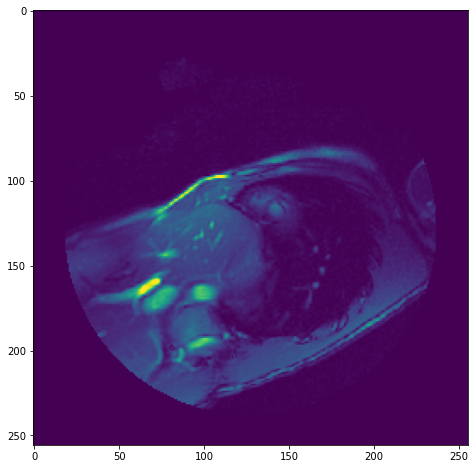

In [29]:
plt.imshow(im)

Apply a median filter to im. Set the size to 3.

In [30]:
im_filt = ndi.median_filter(im, size =3)

Create a mask of values greater than 60, then use `ndi.binary_closing()` to fill small holes in it.

In [31]:
mask_start = np.where(im_filt > 60, 1, 0)
mask = ndi.binary_closing(mask_start)

Extract a labeled array and the number of labels using `ndi.label()`.

In [32]:
labels, nlabels = ndi.label(mask)
print('Num. Labels:', nlabels)

Num. Labels: 22


In [33]:
boxes = ndi.find_objects(labels)

In [34]:
print(boxes)

[(slice(82, 86, None), slice(165, 182, None)), (slice(84, 91, None), slice(134, 159, None)), (slice(92, 96, None), slice(145, 155, None)), (slice(93, 99, None), slice(119, 131, None)), (slice(95, 149, None), slice(53, 119, None)), (slice(110, 114, None), slice(133, 139, None)), (slice(114, 120, None), slice(139, 147, None)), (slice(146, 147, None), slice(126, 128, None)), (slice(147, 149, None), slice(101, 103, None)), (slice(153, 179, None), slice(40, 87, None)), (slice(155, 159, None), slice(107, 110, None)), (slice(161, 174, None), slice(86, 110, None)), (slice(171, 220, None), slice(122, 219, None)), (slice(176, 213, None), slice(82, 110, None)), (slice(186, 187, None), slice(177, 178, None)), (slice(188, 218, None), slice(59, 76, None)), (slice(190, 192, None), slice(39, 40, None)), (slice(190, 194, None), slice(112, 116, None)), (slice(193, 195, None), slice(153, 156, None)), (slice(196, 198, None), slice(150, 152, None)), (slice(220, 224, None), slice(113, 123, None)), (slice(22

In [35]:
print(max(boxes))

(slice(223, 232, None), slice(83, 99, None))


Plot the `labels` array on top of the original image. To create an overlay, use `np.where` to convert values of 0 to `np.nan`. Then, plot the overlay with the `rainbow` colormap and set `alpha=0.75` to make it transparent.

In [36]:
overlay = np.where(labels>0, labels, np.nan)

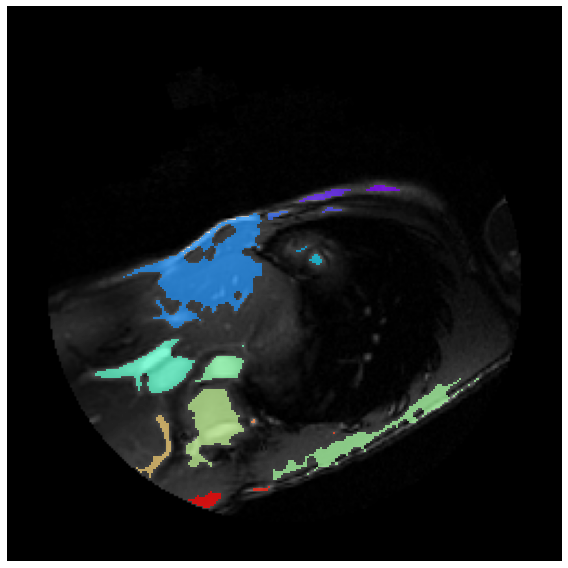

In [37]:
plt.imshow(im, cmap='gray')
plt.imshow(overlay, cmap='rainbow', alpha=0.75)
format_and_render_plot_1()

Use `ndi.label()` to assign labels to each separate object in mask.

In [38]:
labels, nlabels = ndi.label(mask)

Find the index value for the left ventricle `label` by checking the center pixel `(128, 128)`.

In [39]:
lv_val= labels[84,170]

Create a mask of pixels matching the left ventricle label. Using `np.where`, set pixels labeled as `lv_val` to `1` and other values to `np.nan`.

In [40]:
lv_mask = np.where(labels == lv_val, 1, np.nan)

Use `plt.imshow()` to overlay the selected label on the current plot.

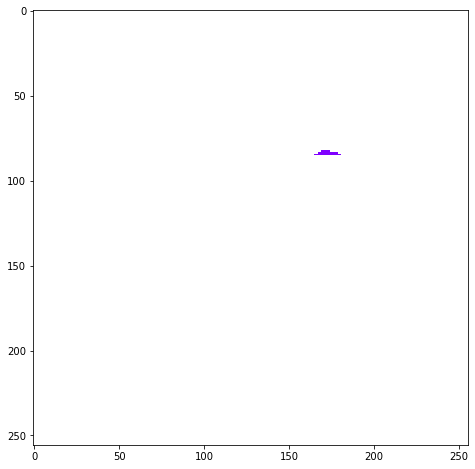

In [41]:
plt.imshow(lv_mask, cmap='rainbow')
plt.show()

Find the bounding box indices for `lv_mask`. Print the number of objects found and the values for the first box

In [42]:
labels, nlabels = ndi.label(mask)
lv_val = labels[84, 170]
lv_mask = np.where(labels == lv_val, 1, 0)

In [43]:
# Find bounding box of left ventricle
bboxes = ndi.find_objects(lv_mask)
print('Number of objects:', len(bboxes))
print('Indices for first box:', bboxes[0])

Number of objects: 1
Indices for first box: (slice(82, 86, None), slice(165, 182, None))


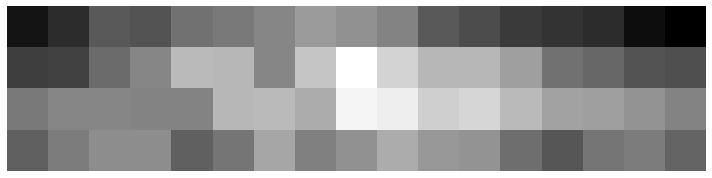

In [44]:
# Crop to the left ventricle (index 0)
im_lv = im[bboxes[0]]

# Plot the cropped image
plt.imshow(im_lv, cmap='gray')
format_and_render_plot_1()

In [45]:
print(bboxes)

[(slice(82, 86, None), slice(165, 182, None))]


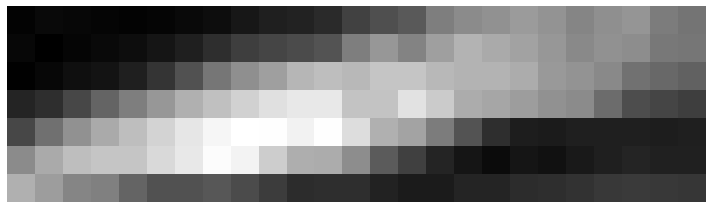

In [46]:
# Crop to the left ventricle (index 0)
im_lv1 = im[boxes[1]]

# Plot the cropped image
plt.imshow(im_lv1, cmap='gray')
format_and_render_plot_1()

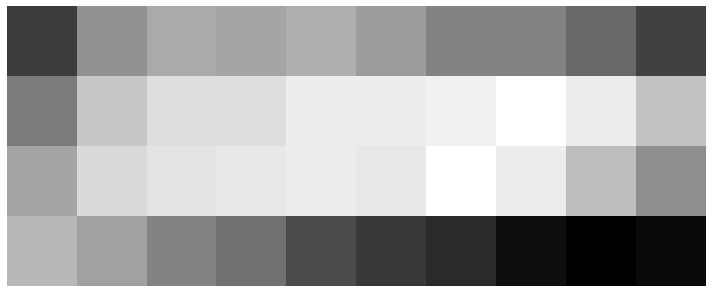

In [47]:
# Crop to the left ventricle (index 0)
im_lv2 = im[boxes[2]]

# Plot the cropped image
plt.imshow(im_lv2, cmap='gray')
format_and_render_plot_1()

As one (somewhat time-consuming and tedious) method, can print each bounding box to find the piece you're looking for

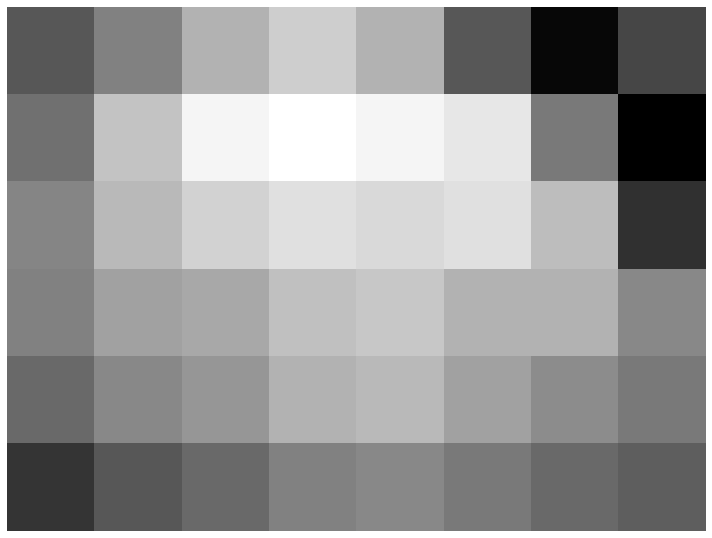

In [48]:
# Crop to the left ventricle (index 0)
im_lv6 = im[boxes[6]]

# Plot the cropped image
plt.imshow(im_lv6, cmap='gray')
format_and_render_plot_1()

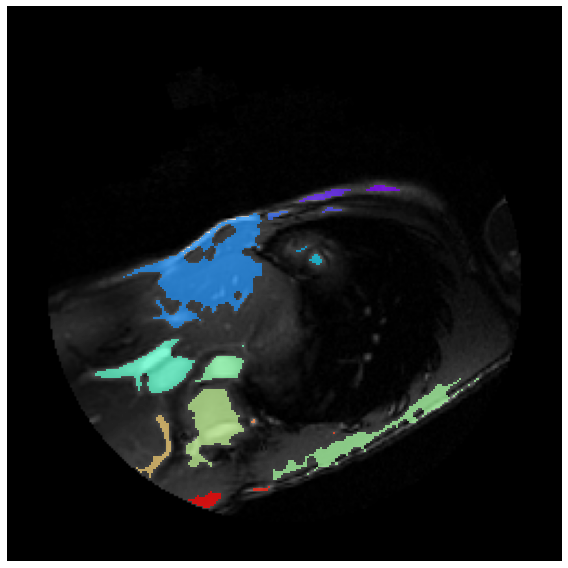

In [49]:
plt.imshow(im, cmap='gray')
plt.imshow(overlay, cmap='rainbow', alpha=0.75)
format_and_render_plot_1()

**To find boxes of largest size:**

In [50]:
im[boxes[0]].size

68

In [51]:
im[boxes[15]].size

510

In [52]:
im[boxes[4]].size

3564

### To print list of bboxes, with sizes:

In [53]:
for n in range(22):
    k = im[boxes[n]].size
    print(n, k)

0 68
1 175
2 40
3 72
4 3564
5 24
6 48
7 2
8 4
9 1222
10 12
11 312
12 4753
13 1036
14 1
15 510
16 2
17 16
18 6
19 4
20 40
21 144


Here we can see that the largest bounding box is bounding box 12.

**NOTE** this is size of pixels of BOUNDING BOXES, not actual object area.

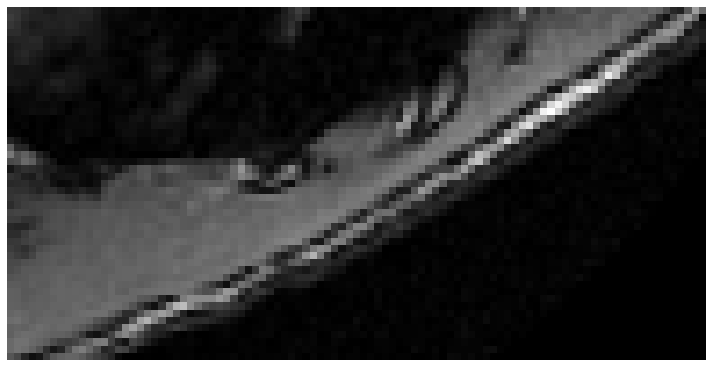

In [54]:
# Crop to the left ventricle (index 0)
im_lv12 = im[boxes[12]]

# Plot the cropped image
plt.imshow(im_lv12, cmap='gray')
format_and_render_plot_1()

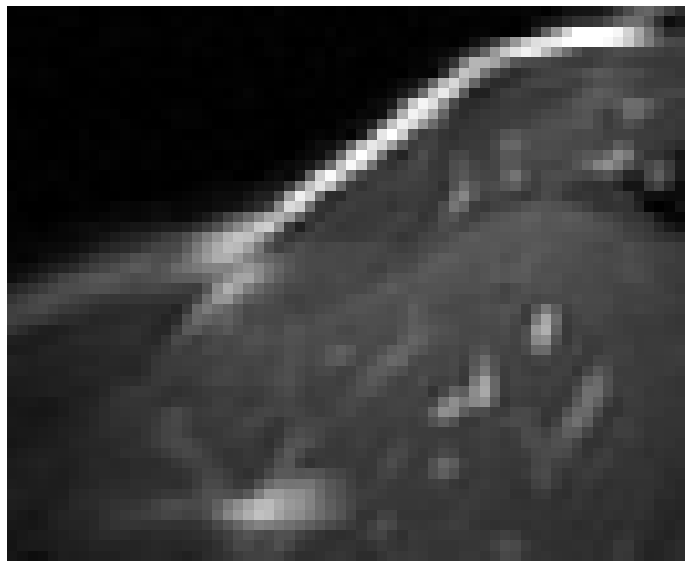

In [55]:
# Crop to the left ventricle (index 0)
im_lv4 = im[boxes[4]]

# Plot the cropped image
plt.imshow(im_lv4, cmap='gray')
format_and_render_plot_1()

In [56]:
print(boxes[4])

(slice(95, 149, None), slice(53, 119, None))


In [57]:
lv_val4 = labels[125,100]

In [58]:
lv_mask4 = np.where(labels == lv_val4, 1, np.nan)

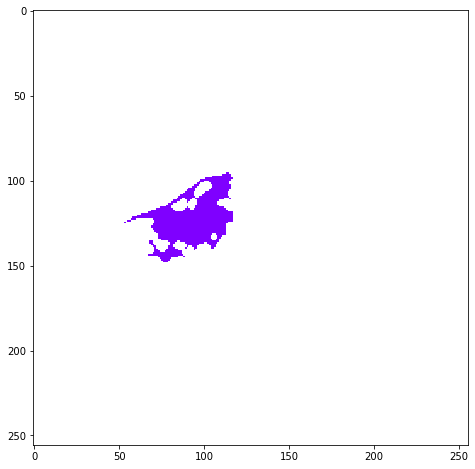

In [59]:
plt.imshow(lv_mask4, cmap='rainbow')
plt.show()

# Double check: is x-axis the vertical axis here and y-axis the horizontal axis?

In [60]:
# Create left ventricle mask
lv_mask4b = np.where(labels == lv_val4, 1, 0)

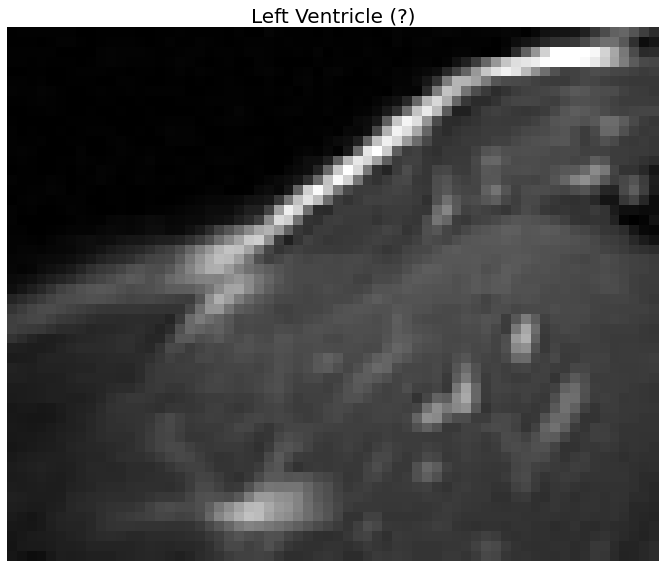

In [61]:
# Crop to the left ventricle (index 0)
im_lv4 = im[boxes[4]]

# Plot the cropped image
plt.imshow(im_lv4, cmap='gray')
plt.title("Left Ventricle (?)", fontsize=20)
format_and_render_plot_1()

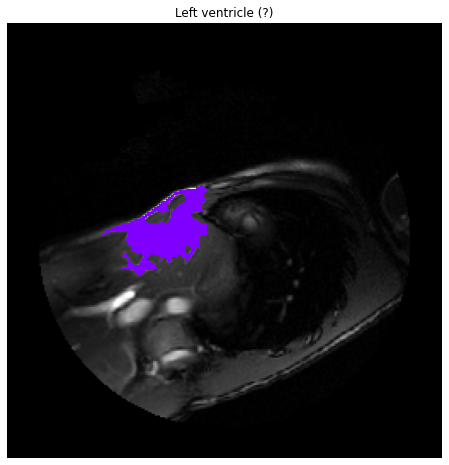

In [62]:
plt.imshow(im, cmap='gray')
plt.imshow(lv_mask4, cmap='rainbow')
plt.axis('off')
plt.title("Left ventricle (?)")
plt.show()

## Measuring Intensity
* Once objects have been segmented from the background, their properties can be efficiently measured using tools within `scipy`
* For this lesson, we'll measure a full three-dimensional volume
* We have the following labels for a single volume of the cardiac time series:
    * 1) Left ventricle (teal)
    * 2) Central portion (red)
    
![Cardiac vol gif](https://assets.datacamp.com/production/repositories/2085/datasets/d9b3a768b1f36d0affe58361c9b0f82bb819833b/Ch3_L4_cardiac-vol-exercise.gif "Cardiac vol")    
* `scipy` has optimized many of the most common descriptive functions for image data, including:
    * **`scipy.ndimage.measurements`**
        * `ndi.mean()`
        * `ndi.median()`
        * `ndi.sum()`
        * `ndi.maximum()`
        * `ndi.standard_deviation()`
        * `ndi.variance()`
    * **The above functions summarize the array across all dimensions of an image, whether it be 2D, 3D, 4D, or more.**
    * They are especially useful when you have a labeled image, because you can apply the function to every object independently with a single call.
    * For **custom calculations**, you can also used the `labeled_comprehension()` function to summarize your data.
        * **`ndi.labeled_comprehension()`**

In [63]:
vol = imageio.volread('sunnybrook-cardiac-mr/SCD2001_006') 

Reading DICOM (examining files): 1/21 files (4.8%21/21 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 21/21  (100.0%)


#### Calling measurement function
* Which arguments you specify when you call measurement functions determins the pixels used for the calculation.
* In the example below, we have loaded the MRI volume and its corresponding labels.
* For more on what a `.npz` file is, see: [here](https://imageio.readthedocs.io/en/v2.5.0/format_npz.html#:~:text=NPZ%20is%20a%20file%20format,supports%20multiple%20images%20per%20file.)
* As previously mentioned, a `.dcm` file is a **DICOM** image file.

```
import imageio
import scipy.ndimage as ndi
vol = imageio.volread(''SCD-3d.npz')
label=imageio.volread('labels.npz')

#All pixels
ndi.mean(vol)

# All labeled pixels
ndi.mean(vol, label)

# Only label #1
ndi.mean(vol, label, index=1)

# Labels 1 and 2
ndi.mean(vol, label, index=[1,2])
```
* **If you provide a mask or laveled array, you will restrict the analysis to all non-zero pixels.**
* However, **if you provide a set of labels and an index value, you can get the mean intensity for a single label.**
* On the other hand, **if you pass a list of values to the index argument, the function will return a list of mean values- one for each object specified.**

In [76]:
# import imageio
# import scipy.ndimage as ndi
ndi.mean(vol)

15.457653227306547

In [77]:
ndi.mean(vol, labels_lv)

99.0607850609756

In [78]:
ndi.mean(vol, labels_lv, index=1)

114.78572355372667

### Object histograms
* In the previous chapter, we simply passed in our image array and then specified the minimum value, maximum value, and the number of bins to use. 
* However, if you also include a label array and indices, `ndi.histogram()` will return distributions for each of the selected labels.

```
hist = ndi.histogram(vol, min=0, max=255, bins=256)
obj_hist = ndi.histogram(vol, 0, 255, 256, labels, index=[1,2])
len(obj_hist)
```
* `2`

* Plotting these object-level histograms is a great way to evaluate your segmentation
    * **If you see very wide distributions o multiple peaks and valleys in your histogram, your labelled object may include (many) different tissue types.**
    
```
plt.plot(obj_hists[0], label='Left ventricle')
plt.plot(obj_hists[1], label='Other labelled pixels')
plt.legend()
plt.show()
```

In [85]:
hist = ndi.histogram(vol, min=0, max=255, bins=256)
obj_hist = ndi.histogram(vol, 0, 255, 256, labels_lv, index=[1,2])
len(obj_hist)

2

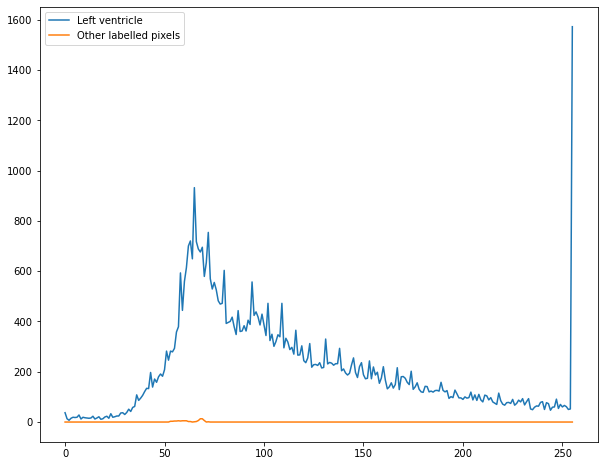

In [117]:
plt.plot(obj_hist[0], label='Left ventricle')
plt.plot(obj_hist[~0], label='Other labelled pixels')
plt.legend()
plt.show()

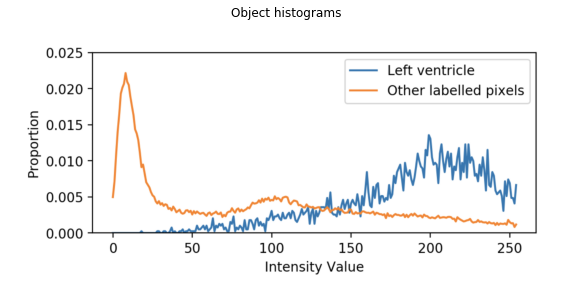

In [84]:
show_image(imread('pics_b/object_histograms.png'), "Object histograms")

* **Histograms containing multiple tissue types will have several peaks.**
* On the other hand, if the histogram resembles a normal distribution, your segmentation may be doing a good job.
    * This is because the physical properties that influence intensity values should be relatively uniform throughout a tissue.

#### Exercises: Measure variance
SciPy measurement functions allow you to tailor measurements to specific sets of pixels:
    * Specifying `labels` restricts the mask to non-zero pixels.
    * Specifying `index` value(s) returns a measure for each label value.
    
For this exercise, calculate the intensity **variance** of vol with respect to different pixel sets. We have provided the 3D segmented image as `labels`: label 1 is the left ventricle and label 2 is a circular sample of tissue.

```
# Variance for all pixels
var_all = ndi.variance(vol, labels=None, index=None)
print('All pixels:', var_all)

# Variance for labeled pixels
var_labels = ndi.variance(vol, labels, index=None)
print('Labeled pixels:', var_labels)

# Variance for each object
var_objects = ndi.variance(vol, labels, index=[1,2])
print('Left ventricle:', var_objects[0])
print('Other tissue:', var_objects[1])
```
* "All pixels" has the lowest variance because it has many pixels with 0 values.

In [87]:
# Variance for all pixels
var_all = ndi.variance(vol, labels=None, index=None)
print('All pixels:', var_all)

# Variance for labeled pixels
var_labels = ndi.variance(vol, labels_lv, index=None)
print('Labeled pixels:', var_labels)

# Variance for each object
var_objects = ndi.variance(vol, labels_lv, index=[1,2])
print('Left ventricle:', var_objects[0])
print('Other tissue:', var_objects[1])

All pixels: 1024.5268017215453
Labeled pixels: 2365.566309168813
Left ventricle: 3246.3323687978077
Other tissue: 32.21768707482996


#### Separate histograms
A poor tissue segmentation includes multiple tissue types, leading to a wide distribution of intensity values and more variance.

On the other hand, a perfectly segmented left ventricle would contain only blood-related pixels, so the histogram of the segmented values should be roughly bell-shaped.

For this exercise, compare the intensity distributions within `vol` for the listed sets of pixels. Use `ndi.histogram`, which also accepts `labels` and `index` arguments.

```
# Create histograms for selected pixels
hist1 = ndi.histogram(vol, min=0, max=255, bins=256)
hist2 = ndi.histogram(vol, 0, 255, 256, labels=labels)
hist3 = ndi.histogram(vol, 0, 255, 256, labels=labels, index=1)
```

```
# Plot the histogram density
plt.plot(hist1 / hist1.sum(), label='All pixels')
plt.plot(hist2 / hist2.sum(), label='All labeled pixels')
plt.plot(hist3 / hist3.sum(), label='Left ventricle')
format_and_render_plot()
```

In [88]:
# Create histograms for selected pixels
hist1 = ndi.histogram(vol, min=0, max=255, bins=256)
hist2 = ndi.histogram(vol, 0, 255, 256, labels=labels_lv)
hist3 = ndi.histogram(vol, 0, 255, 256, labels=labels_lv, index=1)

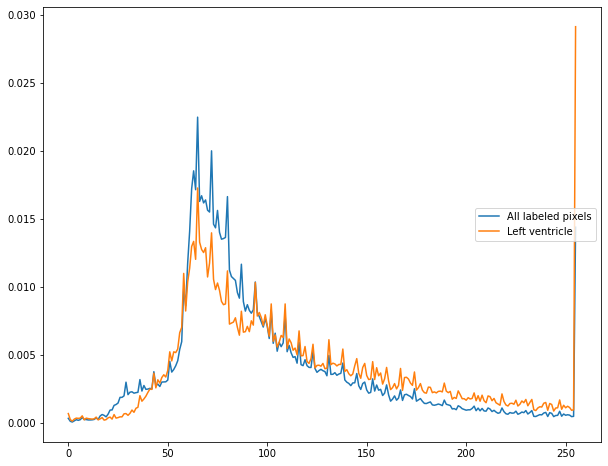

In [91]:
# Plot the histogram density
#plt.plot(hist1 / hist1.sum(), label='All pixels')
plt.plot(hist2 / hist2.sum(), label='All labeled pixels')
plt.plot(hist3 / hist3.sum(), label='Left ventricle')
format_and_render_plot_2()

### Measuring morphology
* Measuring object **morphology**, or shape and size, is another principal aim of image analysis

#### Spatial extent
* **Spatial extent**, or the amount of space occupied by an object, is the product of:
    * 1) Space occupied by each element
    * 2) Number of array elements
* Below we'll calculate the volume of the left ventricle in one of our cardiac images:

* First, we establish the amount of real, physical space taken up by each voxel
    * Recall that in DICOM images, we can find this in the "sampling" field of the metadata dictionary.
    * Multiplying the lengths of the first, second, and third dimensions will give us the total volume at each voxel.
    * In this case (below) the measurements are in cubic millimeters
   

```
# Calculate volume per voxel
d0, d1, d2 = vol.meta['sampling']
dvoxel = d0 * d1 * d2

# Count label voxels
nvoxels = ndi.sum(1, label, index=1)
```

In [92]:
vol.meta.keys()

odict_keys(['TransferSyntaxUID', 'SOPClassUID', 'SOPInstanceUID', 'StudyDate', 'SeriesDate', 'AcquisitionDate', 'ContentDate', 'StudyTime', 'SeriesTime', 'AcquisitionTime', 'ContentTime', 'Modality', 'Manufacturer', 'StudyDescription', 'SeriesDescription', 'PatientName', 'PatientID', 'PatientBirthDate', 'PatientSex', 'SliceSpacing', 'StudyInstanceUID', 'SeriesInstanceUID', 'SeriesNumber', 'AcquisitionNumber', 'InstanceNumber', 'ImagePositionPatient', 'ImageOrientationPatient', 'SamplesPerPixel', 'Rows', 'Columns', 'PixelSpacing', 'BitsAllocated', 'BitsStored', 'HighBit', 'PixelRepresentation', 'PixelData', 'shape', 'sampling'])

In [98]:
vol.meta

Dict([('TransferSyntaxUID', '1.2.840.10008.1.2.1'),
      ('SOPClassUID', '1.2.840.10008.5.1.4.1.1.4'),
      ('SOPInstanceUID', '2.16.124.113543.6006.99.01192790474737228128'),
      ('StudyDate', '20120000'),
      ('SeriesDate', '20120000'),
      ('AcquisitionDate', '20120000'),
      ('ContentDate', '20120000'),
      ('StudyTime', '124424.000000 '),
      ('SeriesTime', '130512'),
      ('AcquisitionTime', '130801.514566 '),
      ('ContentTime', '130810.658232 '),
      ('Modality', 'MR'),
      ('Manufacturer', 'GE MEDICAL SYSTEMS'),
      ('StudyDescription', ''),
      ('SeriesDescription', ''),
      ('PatientName', 'SCD0002001'),
      ('PatientID', 'SCD0002001'),
      ('PatientBirthDate', '00000000'),
      ('PatientSex', ''),
      ('SliceSpacing', 10.0),
      ('StudyInstanceUID', '2.16.124.113543.6006.99.2708664770257691226'),
      ('SeriesInstanceUID', '2.16.124.113543.6006.99.2706040441424892637'),
      ('SeriesNumber', 900),
      ('AcquisitionNumber', 1),
      (

In [99]:
# Calculate volume per voxel
d0, d1, d2 = vol.meta['sampling']
dvoxel = d0 * d1 * d2

In [100]:
dvoxel

0.0

In [106]:
# Count label voxels
nvoxels = ndi.sum(1, labels_lv, index=1)

This function above will weight each left ventricle voxel with a value of 1 and then sum them.

In [107]:
# Calculate volume of label
volume = nvoxels * dvoxel
volume

0.0

* Finally, we multiple the number of voxels by their individual size to get the total volume of the object.

### Distance transformation
* Another useful morphological measure is **the distance of each voxel to the nearest background value.**
* This information can help you identify the most embedded points within objects or mask out edge areas.
* To perform a distance transformation on a mask or label array, use the `dist_transform_edt()` function (**for Euclidean Distance**)

```
# Create a left ventricle mask
mask = np.where(labels ==1, 1, 0)
# In terms of voxels
d = ndi.nistance_transform_edt(mask)
d.max()
```

* This will return a new array, where each non-zero voxel has been replaced with the distance to the nearest background voxel.
* The maximimum value in this case, reflects how far from the edge the most embedded point is.
* If you have access to the sampling rates for each dimension, you can include these to generate values that reflect real physical distance.

```
# In terms of space
d = ndi.distance_transform_edt(mask, sampling=vol.meta['sampling'])
d.max()
```
* In some cases (like the one above) the max distance will be reduced because the sampling rate is less than 1 mm per pixel.

### Center of mass
* A complimentary measure is the **center of mass**, which you can calculate directly.
* Mass, in this case, refers to intensity values, with larger values pulling the center towards them.

```
com = ndi.center_of_mass(vol, labels, index=1)
com
```
* The function returns a tuple of coordinates for each object specified: `(5.5235, 128.0590, 128.0993)`

```
plt.imshow(vol[5], cmap='gray')
plt.scatter(com[2], com[1])
plt.show()
```

### Exercises: Calculate volume
Quantifying tissue *morphology*, or shape is one primary objective of biomedical imaging. The size, shape, and uniformity of a tissue can reveal essential health insights.

For this exercise, measure the *volume* of the left ventricle in one 3D image (`vol`).

First, count the number of voxels in the left ventricle (label value of 1). Then, multiply it by the size of each voxel in mm. (Check `vol.meta` for the sampling rate.)

* Calculate the number of pixels in the left ventricle by calling `ndi.sum(1, labels, index=1)`
* Calculate the unit volume for each pixel by multiplying the sampling rates from `vol.meta['sampling']` together.
* Calculate the volume by multiplying the number of pixels by their unit volume.

```
num_pixels_lv = ndi.sum(1, labels, index=1)
d0, d1, d2 = vol.meta.sampling
unit_volume = d0 * d1 * d2
volume_lv = num_pixels_lv * unit_volume
```
* `120, 731`

### Calculate distance
A *distance transformation* calculates the distance from each pixel to a given point, usually the nearest background pixel. This allows you to determine which points in the object are more interior and which are closer to edges.

For this exercise, use the [Euclidian distance](https://en.wikipedia.org/wiki/Euclidean_distance) transform on the left ventricle object in `labels`.

```
# Calculate left ventricle distances
lv = np.where(labels==0, 1, 0)
dists = ndi.distance_transform_edt(lv, sampling = vol.meta.sampling)

# Report on distances
print('Max distance (mm):', ndi.maximum(dists))
print('Max location:', ndi.maximum_position(dists))

# Plot overlay of distances
overlay = np.where(dists[5] > 0, dists[5], np.nan) 
plt.imshow(overlay, cmap='hot')
format_and_render_plot()
```

### Exercises: pinpoint center of mass
The distance transformation reveals the most embedded portions of an object. On the other hand, `ndi.center_of_mass()` returns the coordinates for the center of an object.

The "mass" corresponds to intensity values, with higher values pulling the center closer to it.

For this exercise, calculate the center of mass for the two labeled areas. Then, plot them on top of the image.

```
# Extract centers of mass for objects 1 and 2
coms = ndi.center_of_mass(vol, labels, index=[1,2])
print('Label 1 center:', coms[0])
print('Label 2 center:', coms[1])

# Add marks to plot
for c0, c1, c2 in coms:
    plt.scatter(c2, c1, s=100, marker='o')
plt.show()
```

## Measuring in Time
* To solve our original problem: how to measure the ejection fraction of a person's heart
* To calculate the ejection fraction, we have to find the left ventricle's volume when it's totally relaxed -- its *maximum* -- and when its fully squeezed -- its *minimum*.
* $ Ejection Fraction = \frac{LV_{max}-LV_{min}}{LV_{max}}$

### Ejection Fraction
#### Procedure
* 1) Segment left ventricle at each time point
* 2) For each 3D volume in the time series, calculate  volume (calculate the colume at each time point sequentially, using a for loop)
* 3) Select minimum and maximum from the results in step 2, which is a 1D time series
* 4) With the minimum and maximum volumes in hand, calculate ejection fraction

### Calculate volume for each time point
* Let's assume that we have access to both the volumetric time series and the segmented left ventricle.
* The data are 4-D, with time as the first dimension

```
# Stored in (t, z, x, y)
vol_ts.shape
labels.shape
```
* `(20, 12, 256, 256)`
* `(20, 12, 256, 256)`

* First, we calculate the volume of each individual voxel.
* We extract the sampling rate along each dimension, then multiply the spatial dimensions together to get the space occupied by each element
* Next, instantiate an empty 1D array to record the volume at each time point
* We then loop through each time point, counting the number o voxels in the left ventricle
* Finally, we multiply the number of voxels by their volume and store the value in the time series array

```
# Calculate voxel volume in mm^3
d0, d1, d2, d3 = vol_ts.meta['sampling']
dvoxel = d1 * d2 * d3

# Instantiate empty list
ts = np.zeros(20)

# Loop through volume time series
for t in range(20):
    nvoxels=ndi.sum(1, labels[t], index=1)
    ts[t] = nvoxels * dvoxel
plt.plot(ts)
plt.show()   
```

* The plot of the data lines up with our expectations: in the first few time points, there is a squeezing action on the ventricle, followed by relaxaion, where it fills up again
* Now, it's simply a matter of selecting the lowest and highest values from the time series and calculating the ejection fraction
* Since `ts` is a numpy array, we can call the `min()` and `max()` methods to retrieve these values.

```
min_vol = ts.min()
max_vol = ts.max()
ejec_frac = (max_vol - min_vol) / max_vol
print(ejec_frac)
```
* **`0.58672`**
* Here, we've put together an estimate of the ejection fraction using scipy- a process that would normally be done by hand by a radiologist
* And, we've done a pretty good job, even with the simple segmentation method: the expert's estimate was 0.60, quite close to our value.
* Of course, this analysis was for a high-quality image of a single subject.
* Evaluating data from many subjects and images allows for more interesting insights about health and disease. 
* We'll discuss techniques and pitfuls of multi-image analysis in the next chapter

### Exercises: Summarize the time series. 
The ejection fraction is the proportion of blood squeezed out of the left ventricle each heartbeat. To calculate it, radiologists have to identify the maximum volume (systolic volume) and the minimum volume (diastolic volume) of the ventricle.

For this exercise, create a time series of volume calculations. There are 20 time points in both `vol_ts` and `labels`. The data is ordered by `(time, plane, row, col)`.

```
# Create an empty time series
ts = np.zeros(20)

# Calculate volume at each voxel
d0, d1, d2, d3 = vol_ts.meta['sampling']
dvoxel = d1 * d2 * d3

# Loop over the labeled arrays
for t in range(20):
    nvoxels = ndi.sum(1, labels[t], index=1)
    ts[t] = nvoxels * dvoxel

# Plot the data
plt.plot(ts)
format_and_render_plot()
```

```
# Get index of max and min volumes
tmax = np.argmax(ts)
tmin = np.argmin(ts)

# Plot the largest and smallest volumes
fig, axes = plt.subplots(2,1)
axes[0].imshow(vol_ts[tmax, 4], vmax=160)
axes[1].imshow(vol_ts[tmin, 4], vmax=160)
format_and_render_plots()
```

```
# Calculate ejection fraction
ej_vol = ts.max() - ts.min()
ej_frac = ej_vol / ts.max()
print('Est. ejection volume (mm^3):', ej_vol)
print('Est. ejection fraction:', ej_frac)
```

# $\star$ Chapter 4: Image Comparison
For the final chapter, you'll need to use your brain... and hundreds of others! Drawing data from more than 400 open-access MR images, you'll learn the basics of registration, resampling, and image comparison. Then, you'll use the extracted measurements to evaluate the effect of Alzheimer's Disease on brain structure.

## Spatial transformations
* Now let's turn our attention to questions that leverage many images at once.
* With a large imaging dataset, there is going to be variability and not just the kind that's interesting
    * There will be differences in intensity scales, sampling ratios, object orientation, and object placement within the image window
    * One way to address some of these issues is to register images to a pre-defined position and coordinate system. 
    
### Registration
* For example, you might make all images line up with a template image or atlas
* The process of aligning two images together is called **registration**
* Registration requires making multiple transformations to an image, such as shifting, rotating, and scaling it. 

#### Registration
* Align images to template
* Minimize spatial variability
* Templates:
    * May represent multiple subjects
    * May be an "average" subject
* Entails many spatial transformations

#### Affine transformations preserve points, lines, and planes
* **Affine:** (adj, mathematics) allowing for or preserving parallel relationships.
* Definition of [Affine](https://www.dictionary.com/browse/affine) and more

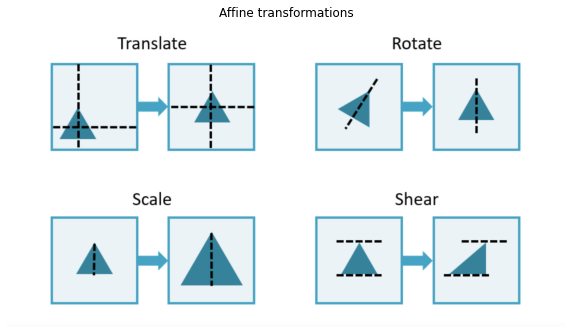

In [111]:
show_image(imread('pics_b/affine_transformations.png'), 'Affine transformations')

* Affine transformations modify an image while preserving all of the points, straight lines, and planes
* Above are four examples of affine transformations.
* **Translation** is the shifting of an image along an axis
    * Can be used to center an object
* **Rotations** will turn the image along a plane
* **Scaling** increases or decreases the size of the image
* **Shearing** shifts the end of an axis away from each other.

### Translation
* Calculate center of image:

```
import imageio
import scipy.ndimage as ndi

im = imageio.imread('QAS1036-2d.dcm')
im.shape
```
* The image is of shape `(256, 256)`, so the center of the image is at `(128,128)`
* Calculate object's (head's) initial center of mass;
* Calculate the difference between the head's current center of mass and the target center, for both the rows and the columns

```
com = ndi.center_of_mass(im)
d0 = 128 -com[0]
d1 = 128 -com[1]
xfm = ndi.shift(im, shift=[d0, d1])
```

* Finally, we call SciPy's `shift()` function, passing in the image and the number of pixels we need to move along the first and second axes


In [118]:
com = ndi.center_of_mass(heart_im)

In [119]:
com[0]

136.30249818116994

In [120]:
com[1]

123.43168570616379

In [121]:
print(com)

(136.30249818116994, 123.43168570616379)


**$\star$ $\Uparrow$ Calculates center of mass for each *labeled* item in image**

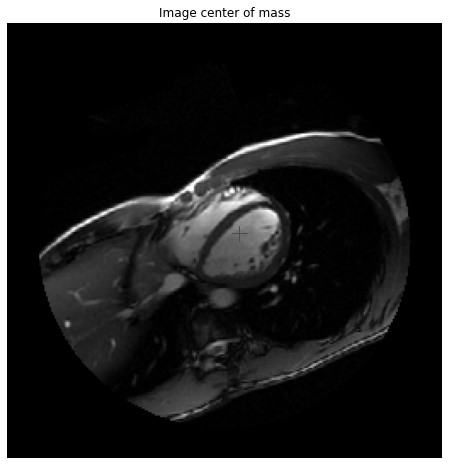

In [132]:
plt.imshow(heart_im, cmap='gray')
for c in com:
    plt.plot(int(com[0]), int(com[1]), '+r', markersize =15)
plt.axis('off')
plt.title('Image center of mass')
plt.show()

In [133]:
com_lv = ndi.center_of_mass(labels_lv)

In [134]:
com_lv

(178.94705829569588, 130.46851912780787)

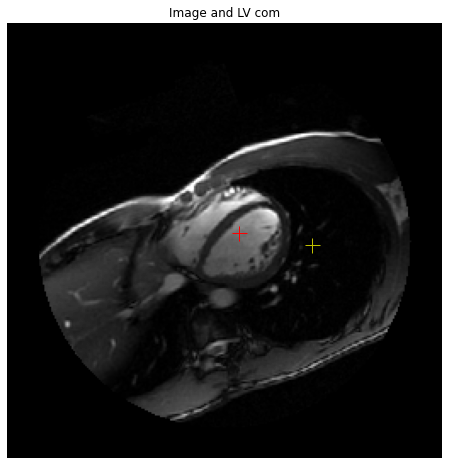

In [144]:
plt.imshow(heart_im, cmap='gray')
plt.plot(int(com[0]), int(com[1]), '+r', markersize =15)
plt.plot(com_lv[0], com_lv[1], '+y', markersize = 15)
plt.axis('off')
plt.title('Image and LV com')
plt.show()

### Rotations
* Rotations caan be performed in a similar manner using the `rotate()` function
* The angle of rotation is specified in degrees, with positive numbers indicating upward from the horizontal, and negative numbers downward
* In two dimensions, we always rotate along the x-y plane, but in three dimensions there are three rotational planes we could use.

```
ndi.rotate(im, angle=25, axes(0,1))
```

* One caveat with the `rotate()` function is that the default behavior preserves all the original data; this means that your rotated image may actually end up larger than your original
* To keep your original image shape, pass `reshape = False` to your function call 

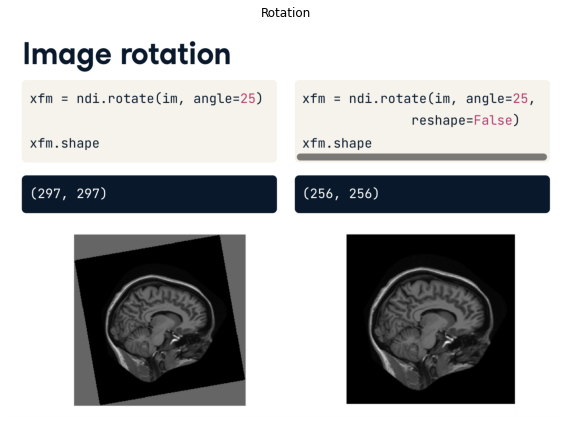

In [113]:
show_image(imread('pics_b/image_rotation2.png'), "Rotation")

### Transformation matrix
* **Transformation matrix:** applied to one image for registration
* For complex registrations, it can be useful to compute a transformation matrix between the original and target space.
* Essentially, the elements of a transformation matrix encode instructions for different affine transformations: translation, rotation, scaling, and shearing
* We don't cover transformation matrices here, but we can demonstrate how they can be used to simplify the registration process

### Applying a transformation matrix
* First, we create the transformation matrix

#### Identity function

```
# Identity matrix
mat = [[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]]
xfm = ndi.affine_transform(im, mat)
```
* We'll first use the **identity matrix**, which has ones along the diagonal and zeros off it.
* We can apply it by passing the image and matrix to the `affine_transform()` function.
* The resulting image is identical to the original

#### Translate and rescale

```
# Translate and rescale
mat = [[0.8, 0, -20],
       [0, 0.8, -10],
       [0,   0,   1]]
xfm = ndi.affine_transform(im, mat)
```
* When we apply this new matrix and plot the result, you can see that the image has been centered and made larger.

### Exercises: Translations
In this chapter, we'll leverage data use data from the [Open Access Series of Imaging Studies](https://www.oasis-brains.org/) to compare the brains of different populations: young and old, male and female, healthy and diseased.

To start, center a single slice of a 3D brain volume (`im`). First, find the center point in the image array and the center of mass of the brain. Then, translate the image to the center.

This chapter's exercises have all had the following imports:

```
import imageio
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
```

```
# Find image center of mass
com = ndi.center_of_mass(im)

# Calculate amount of shift needed
d0 = 128 - com[0]
d1 = 128 - com[1]

# Translate the brain towards the center
xfm = ndi.shift(im, shift=[d0,d1])

# Plot the original and adjusted images
fig, axes = plt.subplots(2, 1)
axes[0].imshow(im)
axes[1].imshow(xfm)
format_and_render_plot()
```

### Exercises: Rotations
In cases where an object is angled or flipped, the image can be rotated. Using `ndi.rotate()`, the image is rotated from its center by the specified degrees from the right horizontal axis.

For this exercise, shift and rotate the brain image (`im`) so that it is roughly level and "facing" the right side of the image.

```
# Shift the image towards the center
xfm = ndi.shift(im, shift=(-20, -20))

# Rotate the shifted image
xfm = ndi.rotate(xfm, angle=-30, reshape=False)

# Plot the original and transformed images
fig, axes = plt.subplots(2, 1)
axes[0].imshow(im)
axes[1].imshow(xfm)
format_and_render_plot()
```

### Affine transform
An affine transformation matrix provides directions for up to four types of changes: translating, rotating, rescaling and shearing. The elements of the matrix map the coordinates from the input array to the output.

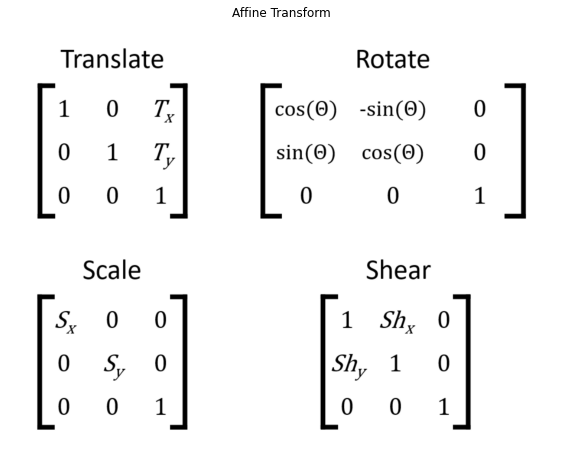

In [145]:
show_image(imread('pics_b/affine_transform.png'), "Affine Transform")

For this exercise, use `ndi.affine_transform()` to apply the following registration matrices to `im`. Which one does the best job of **centering, leveling and enlarging the original image**?

```
ndi.affine_transform(im, [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
```
* $\Uparrow$ Identity matrix

```
ndi.affine_transform(im, [[1.5, -0.8, 60], [0.8, 1.5, -140], [0, 0, 1]])
```

```
ndi.affine_transform(im, [[1, -0.3, 60], [-0.3, 1, 60], [0, 0, 1]])
```

```
ndi.affine_transform(im, [[0.8, -0.4, 90], [0.4, 0.8, -6.0], [0, 0, 1]])
```

* **ANSWER:** (D) `ndi.affine_transform(im, [[0.8, -0.4, 90], [0.4, 0.8, -6.0], [0, 0, 1]])`

## Resampling and interpolation
* When comparing images, differences in array shape and sampling rates can pose hurdles to analysis
* **Resampling** is one way to address this issue.
* **Resampling is the process of slicing your data onto a different array.**

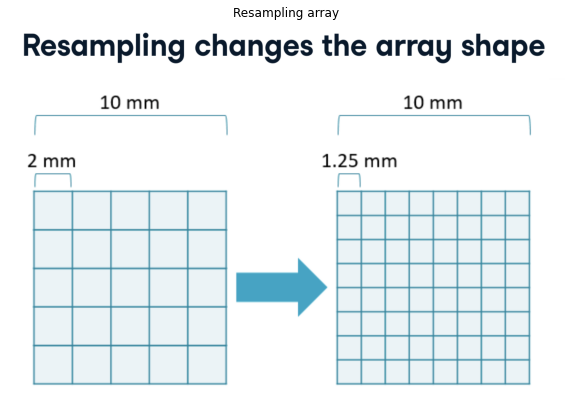

In [146]:
show_image(imread('pics_b/resampling_array.png'), "Resampling array")

* Resampling is distince from cropping in that the **field of view** does not change
* Instead, the amount of space sampled by each pixel is increased or decreased, which in turn changes the shape of the array 

### Downsampling
* One useful application of resampling is **downsampling**, in which information is merged across multiple pixels to reduce the image size


```
vol = imageio.volread('OAS1_0255')
vol.shape
```
* `(256, 256, 256)`
* We'll halve this grid size using scipy's `zoom()` function :

```
vol_dn = ndi.zoom(vol, zoom=0.5)
vol_dn.shape
```
* `(128, 128, 128)`
* **`zoom()`** adjusts the number of elements along each axis by a given factor 
* Plotting the image reveals that it now has less detail than before, but it also takes up half the amount of memory

### Upsampling
* It's also possible to **upsample onto larger (denser) grids**.
* **Note:** this does not result in a true increase in resolution, and is **not the same as collecting higher-resolution data.**
* Even though you're putting more pixels into your image, you are not adding new information that wasn't there previously
* **Useful for standardizing sampling rates that are unequal** (For example: to make voxels cubic)
* To upsample an image, we call the `zoom()` function and specify a larger zoom factor (greater that one).
* For example, passing in `zoom = 2` will double the length of each axis

```
vol_up = ndi.zoom(vol, zoom=2)
vol_up.shape
```
* `(512, 512, 512)`

### Interpolation
* Resampling actually creates a brand new image that's *based* on the old one. In most cases, filling out this new image requires estimating data that wasn't originally there. This estimation process is called interpolation.
* **Interpolation** "stitches together" grid points to model the space between points

#### Interpolation approaches:
    * **Nearest-neighbor:** Uses the closest measured value
        * This is a zero-order interpolation because we aren't modeling any relationship between the original values.
        * `order = 0`
    * **B-spline interpolation:** For higher-order estimation, B-spline interpolation models the space between points with spline functions of a specified order. 
        * the order controls how complex these functions can be: 
            * an order of `1` is linear
            * and order of `2` is quadratic
            * ... and so on.
        * `order` between `1` and `5`
      
### Interpolation in 2D
* Here we've created a ten by ten toy image of ascending values:
* `im = np.arange(100).reshape([10,10])`
* If we resample it onto a 100 x 100 grid, changing the order will affect the smoothness of the resulting image.

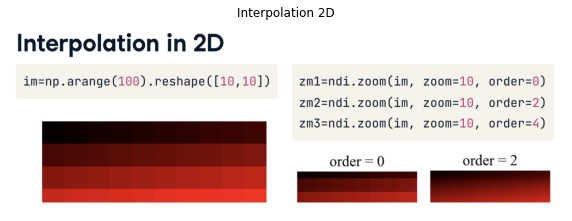

In [147]:
show_image(imread('pics_b/interpolation_2D.png'), "Interpolation 2D")

* With an order of 0, we return essentially the original image on a new grid
* At higher orders though, we can see a smoother gradient of change along each axis 

* **The principal trade-off with lower- and high-order interpolation is in the computational time.**
    * Fifth-order interpolation for a 3D volume can take a VERY long time to calculate! (naturally)

### Exercises: Resampling
Images can be collected in a variety of shapes and sizes. *Resampling* is a useful tool when these shapes need to be made consistent. Two common applications are:

* Downsampling: combining pixel data to *decrease* size
* Upsampling: distributing pixel data to *increase* size

For this exercise, transform and then resample the brain image (`im`) to see how it affects image shape.

```
# Center and level image
xfm = ndi.shift(im, shift=(-20, -20))
xfm = ndi.rotate(xfm, angle=-35, reshape=False)

# Resample image
im_dn = ndi.zoom(xfm, zoom=0.25)
im_up = ndi.zoom(xfm, zoom=4)

# Plot the images
fig, axes = plt.subplots(2, 1)
axes[0].imshow(im_dn)
axes[1].imshow(im_up)
format_and_render_plot()
```

### Exercises: Interpolation
*Interpolation* is how new pixel intensities are estimated when an image transformation is applied. It is implemented in SciPy using [sets of spline functions](https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html).

Editing the interpolation `order` when using a function such as `ndi.zoom()` modifies the resulting estimate: higher orders provide more flexible estimates but take longer to compute.

For this exercise, upsample `im` and investigate the effect of different interpolation orders on the resulting image.

```
# Upsample "im" by a factor of 4
up0 = ndi.zoom(im, zoom=4, order=0)
up5 = ndi.zoom(im, zoom=4, order=5)

# Print original and new shape
print('Original shape:', im.shape)
print('Upsampled shape:', up0.shape)

# Plot close-ups of the new images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(up0[128:256, 128:256])
axes[1].imshow(up5[128:256, 128:256])
format_and_render_plots()
```

### Comparing images
* How can you tell if images are registered well?
* How would you compare an automatically segmented image with a hand-labeled one?
* To directly compare two arrays, you have to generate measures of **image similarity.**

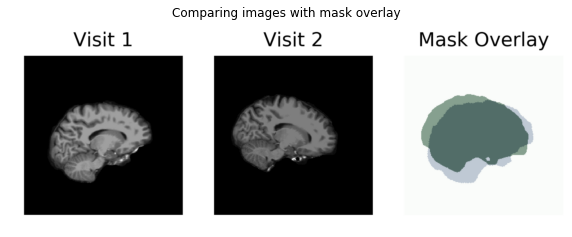

In [148]:
show_image(imread('pics_b/mask_overlay.png'), "Comparing images with mask overlay")

## Summary metrics
* At the pixel level, there can be thousands and thousands of comparison points between two images
* **Goal:** *define* a metric of similarity between two images. 
* Our need is to summarize all of these comparisons into a single number

* **Cost functions** produce metrics to be *minimized*.
    * Examples: MSE, MAE
* **Objective functions** produce metrics to be *maximized*.
    * Example: intersection of the union
    
### Mean absolute error: comparing images
* Cost function, minimizing function
* We find the error at each pixel by subtracting `im2` from `im1`

```
import imageio
import numpy as np
i1 = imageio.imread('OAS`035-v1.dcm')
i2 = imageio.imread('OAS1035-v2.dcm')

err = i1 - i2
plt.imshow(err)

abs_err = np.abs(err)
plt.imshow(abs_err)

mae = np.mean(abs_err)
print(mae)
```
* `29.8570`

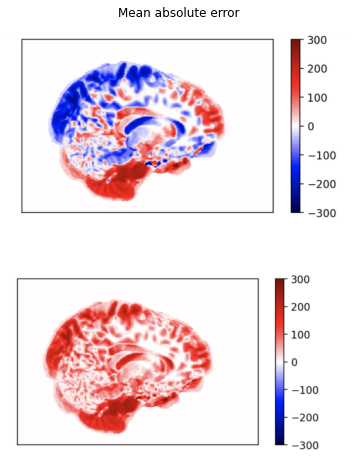

In [149]:
show_image(imread('pics_b/MAE_brain.png'), "Mean absolute error")

* **We take absolute value of the error because we care about whether the images differ from each other in any way, not whether one is larger than the other.** *See bottom pic, all red*
* **MAE**: 29.8570
* **Goal**: *minimize* the cost function; goal is *not* to achieve an mae of zero (that would mean the images were identical, which is not the case in the example, and is typically not the goal)
* **Instead**, you want to minimize the cose function by altering one or both images


* Below we will shift and rotate the first image and then recompute the mae cost

```
# Improve im1 alighnment to im2
xfm = ndi.shift(im1, shift=(-8, -8))
sfm=ndi.rotate(xfm, -18, reshape=False)

# Calculate cost
abs_err = np.abs(im1-im2)
mean_abs_err = np.mean(abs_err)
print(mean_abs_err)
```
* `13.0376`

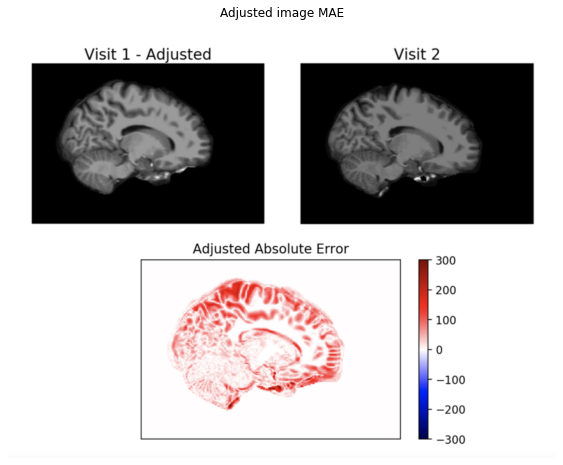

In [150]:
show_image(imread('pics_b/mae_adjusted.png'), "Adjusted image MAE")

* The new cost is lower than the previous one, suggesting that the two are better aligned than before

#### Intersection of the union
* One issue with the mean absolute error approach is that tissues with high-intensity values will contribute more towards the error than other types.
* **One remedy is to compare the image masks.**
* The **intersection of the union** is a measure particularly well-suited to this.
    * It is calculated by dividing the number of shared pixels between two masks by the total number of masked pixels
* First, we create image masks by selecting pixels greater than 0
* Second, we take the **intersection** of the two masks: that is, the pixels that appear in both masks.

```
mask1 = im1 > 0
mask2 = im2 > 0
intsxn = mask1 & mask2
plt.imshow(intsxn)
```
* Next, we find the **union**: the pixels that appear in either mask 

```
union = mask1 | mask2
plt.imshow(union)
```

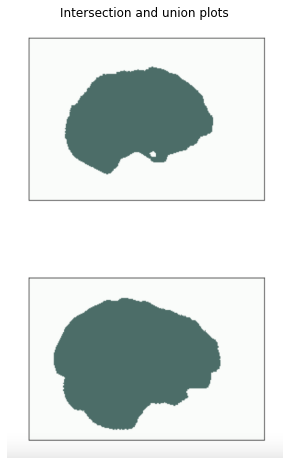

In [152]:
show_image(imread('pics_b/int_un.png'), "Intersection and union plots")

* Finally, we divide the sum of the intersection by the sum of the union:

```
iou = intsxn.sum() / union.sum()
print(iou)
```
* `0.68392`

* **The result is a number between 1 and 0, with 0 representing no shared mask pixels, and 1 representing perfect agreement**
* The principle here is that summarizing image similarity with a single number gives you something to optimize when processing your images.

### Mean absolute error
*Cost functions* and *objective functions* output a single value that summarizes how well two images match.

The **mean absolute error (MAE)**, for example, summarizes intensity differences between two images, with higher values indicating greater divergence.

For this exercise, calculate the mean absolute error between `im1` and `im2` step-by-step.

```
# Calculate image difference
err = im1 - im2

# Plot the difference
plt.imshow(err, cmap='seismic', vmin=-200, vmax=200)
format_and_render_plot()

# Calculate absolute image difference
abs_err = np.abs(im1 - im2)

# Plot the difference
plt.imshow(abs_err, cmap='seismic', vmin=-200, vmax=200)
format_and_render_plot()

# Calculate mean absolute error
mean_abs_err = np.mean(np.abs(im1 - im2))
print('MAE:', mean_abs_err)
```

### Exercises: Intersection of the union
Another cost function is the intersection of the union (IOU). The IOU is the number of pixels filled in both images (the *intersection*) out of the number of pixels filled in either image (the *union*).

For this exercise, determine how best to transform `im1` to **maximize** the IOU cost function with `im2`. We have defined the following function for you:

```
def intersection_of_union(im1, im2):
    i = np.logical_and(im1, im2)
    u = np.logical_or(im1, im2)
    return i.sum() / u.sum()

```
* *Note: When using `ndi.rotate()`, remember to pass `reshape=False`, so that array shapes match.*
* **ANSWER:** Shift (-10, -10), rotate -15 deg.

### Normalizing measurements
* To round out the course, we'll discuss the importance of accounting for confounds when comparing images
* Shown below is a common multi-subject workflow:

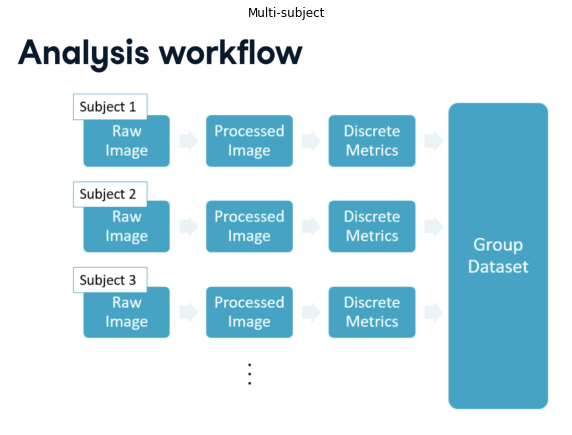

In [154]:
show_image(imread('pics_b/analysis_workflow.png'), "Multi-subject")

* Each subject has a raw image that we process, measure, and store in a common group dataset
* In the above model, each image is treated independently, but you are extracting the same metrics from each subject
* For this lesson, we'll assume that we have measured the brain volumes for all 400 images in the OASIS dataset and stored them in a pandas DataFrame
* To test the null hypothesis that mean brain volumes of men and women are the same, we will use a **two-sample t-test** with `scipy.stats.ttest_ind()`
    * The likelihood of the null hypothesis being true is assessed by calculating the t-statistic
    * If the magnitude of t is very far from 0, then we can reject the null hypothesis that the groups are the same

#### Hypothesis testing
* To run the t-test, we need the brain volumes for all of the males and females in our sample

```
from scipy.stats import ttest_ind
brain_m = df.loc[df.sex == 'M', 'brain_vol']
brain_f = df.loc[df.sex == 'F', 'brain_vol']
results = ttest_ind(brain_m, brain_f)

results.statistic
results.pvalue
```
* `10.20986`
* `5.03913e-22`
* In this case, we have a large t-statistic, and a low p-value, suggesting that there is a significant difference in gender brian size.

#### Correlated measurements
* We need to consider the context in which this measurement is acquired
* Brains fill up skulls, and skulls are proportional to body size
* If we compare brain and skull volumes, we find that they have quite a large correlation:

* `df[['brain_vol', 'skull_vol']].corr()`
* Accounting for this shared variation is important if we want to state that there's something different about the brains of men and women and not just their body size.

### Normalization
* To account for this potential confound, we can normalize brain volume with respect to skull size by calculating the brain to skull ratio
* We can then repeat our t-test using the normalized values for males and females.

```
df['brain_norm'] = df.brain_vol / df.skull_vol
brain_norm_m = df.loc[df.sex == 'M', 'brain_norm']
brain_norm_f = df.loc[df.sex == 'F', 'brain_norm']
results = ttest_ind(brain_norm_m, brain_norm_f)

results.statistic
results.pvalue
```
* `-0.94911`
* `0.34769`
* Confounds are omnipresent in data science, but can be especially pervasive in image analyses
* If you are pooling data across multiple hospitals or sites, you must consider how image acquisition, digital storage, clinical protocols, and subject populations might be biased towards a particular result.

### Exercises: Identifying potential confounds
Once measures have been extracted, double-check for dependencies within your data. This is especially true if any image parameters (sampling rate, field of view) might differ between subjects, or you pull multiple measures from a single image.

For the final exercises, we have combined demographic and brain volume measures into a pandas DataFrame (`df`).

First, you will explore the table and available variables. Then, you will check for correlations between the data.

```
# Print random sample of rows
print(df.sample(3))

# Print prevalence of Alzheimer's Disease
print(df.alzheimers.value_counts())


# Print a correlation table
print(df.corr())
```

### Exercises: testing group differences

Let's test the hypothesis that Alzheimer's Disease is characterized by reduced brain volume.

We can perform a **two-sample t-test** between the brain volumes of elderly adults with and without Alzheimer's Disease. In this case, the two population samples are *independent* from each other because they are all separate subjects.

For this exercise, use the OASIS dataset (`d`f) and `ttest_ind` to evaluate the hypothesis.

```
# Import independent two-sample t-test
from scipy.stats import ttest_ind

# Select data from "alzheimers" and "typical" groups
brain_alz = df.loc[df.alzheimers == True, 'brain_vol']
brain_typ = df.loc[df.alzheimers == False, 'brain_vol']

# Perform t-test of "alz" > "typ"
results = ttest_ind(brain_alz, brain_typ)
print('t = ', results.statistic)
print('p = ', results.pvalue)

# Show boxplot of brain_vol differences
df.boxplot(column='brain_vol', by='alzheimers')
plt.show()
```

### Exercises: Normalizing metrics
We previously saw that there was not a significant difference between the brain volumes of elderly individuals with and without Alzheimer's Disease.

But could a correlated measure, such as "skull volume" be masking the differences?

For this exercise, calculate a new test statistic for the comparison of brain volume between groups, after adjusting for the subject's skull size.

Using `results.statistic` and `results.pvalue` as your guide, answer the question: **Is there strong evidence that Alzheimer's Disease is marked by smaller brain size, relative to skull size?**

```
# Import independent two-sample t-test
from scipy.stats import ttest_ind

# Divide `df.brain_vol` by `df.skull_vol`
df['adj_brain_vol'] = df.brain_vol / df.skull_vol

# Select brain measures by Alzheimers group
brain_alz = df.loc[df.alzheimers == True, 'adj_brain_vol']
brain_typ = df.loc[df.alzheimers == False, 'adj_brain_vol']

# Evaluate null hypothesis
results = ttest_ind(brain_alz, brain_typ)
```